In [9]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from tqdm import tqdm
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
print("CUDA available:", torch.cuda.is_available())  
print("CUDA version:", torch.version.cuda)          
print("Device:", torch.device("cuda"))             
print("GPU name:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
CUDA version: 13.0
Device: cuda
GPU name: NVIDIA GeForce RTX 3060


In [11]:
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
dataset = datasets.ImageFolder(root='Faulty_solar_panel', transform=transform)
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)
num_classes = len(dataset.classes)


Dataset size: 1207
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [12]:
orig_indices = []
aug_indices = []

for idx, (path, _) in enumerate(dataset.samples):
    filename = os.path.basename(path)
    if filename.startswith("aug_"):
        aug_indices.append(idx)
    else:
        orig_indices.append(idx)

print("Original Count:", len(orig_indices))
print("Augmented Count:", len(aug_indices))

Original Count: 885
Augmented Count: 322


In [13]:
total_orig = len(orig_indices)
val_size = int(total_orig * 0.15)
test_size = int(total_orig * 0.15)
train_orig_size = total_orig - val_size - test_size

train_orig, val_orig, test_orig = random_split(
    orig_indices, [train_orig_size, val_size, test_size]
)

train_indices = list(train_orig) + aug_indices
val_indices = list(val_orig)
test_indices = list(test_orig)

train_ds = Subset(dataset, train_indices)
val_ds   = Subset(dataset, val_indices)
test_ds  = Subset(dataset, test_indices)

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 943
Validation size: 132
Test size: 132


In [14]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=4,drop_last=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4, drop_last=True)

print("Train size:", len(train_loader.dataset))
print("Validation size:", len(val_loader.dataset))
print("Test size:", len(test_loader.dataset))

Train size: 943
Validation size: 132
Test size: 132


In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [3,256,256] -> [16,128,128]
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride=2,padding=1),    # [16,128,128] -> [32,64,64]
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride=2,padding=1),    # [32,64,64] -> [64,32,32]
            nn.ReLU(),
            nn.Conv2d(64,128,3,stride=2,padding=1),   # [64,32,32] -> [128,16,16]
            nn.ReLU(),
            nn.Conv2d(128,256,3,stride=2,padding=1),   # [64,32,32] -> [128,16,16]
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon

autoencoder = Autoencoder().to(device)


In [16]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
num_ae_epochs = 40
ae_losses = torch.zeros(num_ae_epochs)

for epoch in range(num_ae_epochs):
    batchLoss = []
    for images, _ in train_loader:
        images = images.to(device)
        outputs = autoencoder(images)
        loss = ae_criterion(outputs, images)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        batchLoss.append(loss.item())

    epoch_loss = sum(batchLoss) / len(batchLoss)
    ae_losses[epoch] = epoch_loss
    if(epoch % 8 == 0):
        print(f"AE Epoch [{epoch+1}/{num_ae_epochs}], Loss: {epoch_loss:.6f}")

print(f"Final loss: {ae_losses[-1]:.6f}")



AE Epoch [1/40], Loss: 0.491617
AE Epoch [9/40], Loss: 0.195139
AE Epoch [17/40], Loss: 0.188740
AE Epoch [25/40], Loss: 0.184829
AE Epoch [33/40], Loss: 0.184173
Final loss: 0.183823


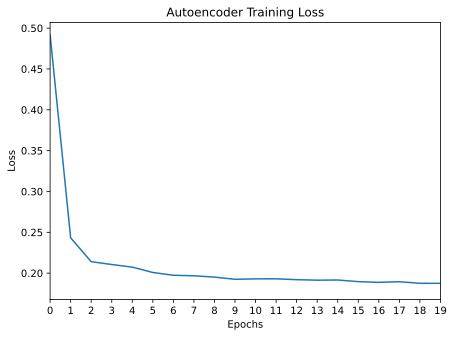

In [17]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(ae_losses.cpu().numpy())
ax.set_xticks(np.arange(0, num_ae_epochs, 1))
ax.set_xlabel('Epochs')
ax.set_title('Autoencoder Training Loss')
ax.set_ylabel('Loss')
ax.set_xlim([0,19])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


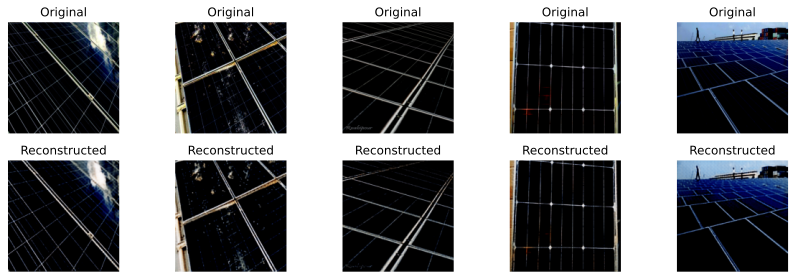

In [18]:
with torch.no_grad():
    images, _ = random.choice(list(test_loader))
    images = images.to(device)
    outputs = autoencoder(images)
    
    images = images.cpu()
    outputs = outputs.cpu()

num_images = 5
plt.figure(figsize=(12, 4))
for i in range(num_images):

    plt.subplot(2, num_images, i+1)
    plt.imshow(images[i].permute(1,2,0).numpy())
    plt.title("Original")
    plt.axis("off")


    plt.subplot(2, num_images, i+1+num_images)
    plt.imshow(outputs[i].permute(1,2,0).numpy())
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
class Classifier(nn.Module):
    def __init__(self, latent_channels=256, num_classes=6):
        super(Classifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latent_channels,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
    def forward(self,x):
        x = self.pool(x)
        x = self.fc(x)
        return x

classifier = Classifier(latent_channels=256, num_classes=num_classes).to(device)

In [20]:
for param in autoencoder.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(autoencoder.encoder.parameters()) + list(classifier.parameters()), lr=1e-4)

In [22]:
print("Training classifier with encoder fine-tuning...")
num_epochs = 300
losses = torch.zeros(num_epochs)
train_acc  = []
val_acc = []
for epoch in range(num_epochs):
    batch_acc  = []
    batch_loss = []
    
    autoencoder.encoder.train()
    classifier.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        latent = autoencoder.encoder(images)
        outputs = classifier(latent)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_acc.append(100*torch.mean((torch.argmax(outputs,axis=1) == labels).float()).item())

    train_acc.append(np.mean(batch_acc))
    losses[epoch] = np.mean(batch_loss)
    

    
    autoencoder.encoder.eval()
    classifier.eval()
    val_batch_acc = []
    for images_val, labels_val in val_loader:
         
        with torch.no_grad():
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            latent_val = autoencoder.encoder(images_val)
            outputs_val = classifier(latent_val)
            val_batch_acc.append(100*torch.mean((torch.argmax(outputs_val,axis=1)==labels_val).float()).item())
    
    val_acc.append(np.mean(val_batch_acc))
    if(epoch % 10 == 0):
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {losses[epoch]:.4f}, Train Accuracy: {train_acc[epoch]:.2f}%, Validation Accuracy: {val_acc[epoch]:.2f}%")

print(f"Final Loss: {losses[-1]:.4f}, Final Train Accuracy: {train_acc[-1]:.2f}%, Final Validation Accuracy: {val_acc[-1]:.2f}%")

Training classifier with encoder fine-tuning...
Epoch [1/300] Loss: 1.3300, Train Accuracy: 46.01%, Validation Accuracy: 58.59%
Epoch [11/300] Loss: 1.2965, Train Accuracy: 48.71%, Validation Accuracy: 58.59%
Epoch [21/300] Loss: 1.2629, Train Accuracy: 48.71%, Validation Accuracy: 57.81%
Epoch [31/300] Loss: 1.1925, Train Accuracy: 52.37%, Validation Accuracy: 58.59%
Epoch [41/300] Loss: 1.1343, Train Accuracy: 57.87%, Validation Accuracy: 56.25%
Epoch [51/300] Loss: 1.0845, Train Accuracy: 55.71%, Validation Accuracy: 57.03%
Epoch [61/300] Loss: 1.0641, Train Accuracy: 58.30%, Validation Accuracy: 54.69%
Epoch [71/300] Loss: 1.0034, Train Accuracy: 61.75%, Validation Accuracy: 52.34%
Epoch [81/300] Loss: 0.9090, Train Accuracy: 64.33%, Validation Accuracy: 53.91%
Epoch [91/300] Loss: 0.9199, Train Accuracy: 63.90%, Validation Accuracy: 53.91%
Epoch [101/300] Loss: 0.8507, Train Accuracy: 66.27%, Validation Accuracy: 53.91%
Epoch [111/300] Loss: 0.7711, Train Accuracy: 70.91%, Validat

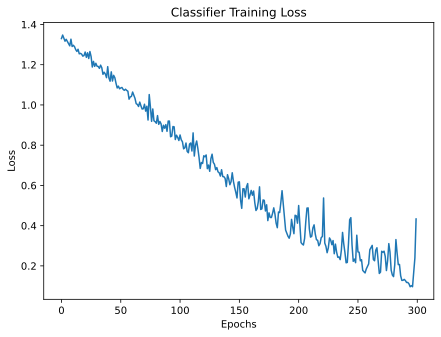

In [23]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(losses.cpu().numpy())
ax.set_title('Classifier Training Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

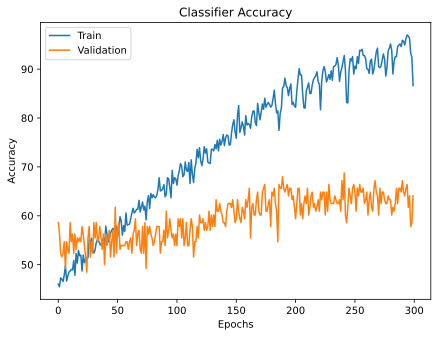

Mean training Accuracy on last 10 epochs:  94.52%
Mean validation Accuracy on last 10 epochs:  63.44%


In [24]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(train_acc)
ax.plot(val_acc)
ax.set_title('Classifier Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

print("Mean training Accuracy on last 10 epochs: ", f"{np.mean(train_acc[-10:]):.2f}%")
print("Mean validation Accuracy on last 10 epochs: ", f"{np.mean(val_acc[-10:]):.2f}%")

In [27]:
date_str = datetime.now().strftime("%y%m%d")
fresh_model = f"models/model{date_str}.pth"
torch.save({
    'epoch': epoch,
    'encoder': autoencoder.encoder.state_dict(),
    'model_state': classifier.state_dict(),
    'optimizer_state': optimizer.state_dict(),
}, fresh_model)

In [ ]:
autoencoder = Autoencoder().to(device)
classifier = Classifier(num_classes=num_classes).to(device)


checkpoint = torch.load(fresh_model, map_location=device)
autoencoder.encoder.load_state_dict(checkpoint['encoder'])
classifier.load_state_dict(checkpoint['model_state'])
autoencoder.eval()
classifier.eval()


with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = autoencoder.encoder(images)
    outputs = classifier(latent)
_, preds = torch.max(outputs,1)
print("Predicted classes:", preds.cpu().numpy())
print("True classes:     ", labels.numpy())

Predicted classes: [0 4 1 1 4 5 0 5 1 1 5 5 3 2 0 0 1 3 2 1 1 1 2 1 2 0 1 2 5 2 2 2]
True classes:      [0 0 3 1 4 5 4 5 1 2 5 5 3 5 0 1 0 3 2 2 1 1 2 3 2 3 2 2 5 3 0 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


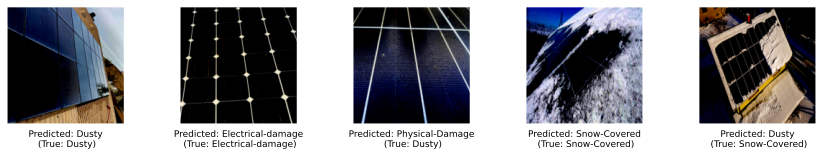

In [29]:
autoencoder.eval()
classifier.eval()
with torch.no_grad():
    
    images, labels = random.choice(list(test_loader))
    images = images.to(device)

    latent = autoencoder.encoder(images)
    output = classifier(latent)
    preds = torch.argmax(output, 1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()


num_images = 5
plt.figure(figsize=(12, 4))
for i in range(num_images):
    
    plt.subplot(2, num_images, i+1)
    plt.imshow(images[i].permute(1,2,0).numpy())
    plt.axis("off")
    true_label = dataset.classes[labels[i].item()]
    pred_label = dataset.classes[preds[i].item()]
    plt.text(
        0.5, -0.20,
        f"Predicted: {pred_label}\n (True: {true_label})",
        fontsize=9,
        ha="center",
        transform=plt.gca().transAxes
    )
    

plt.tight_layout()
plt.show()

Test Accuracy:  57.81%


<Figure size 800x800 with 0 Axes>

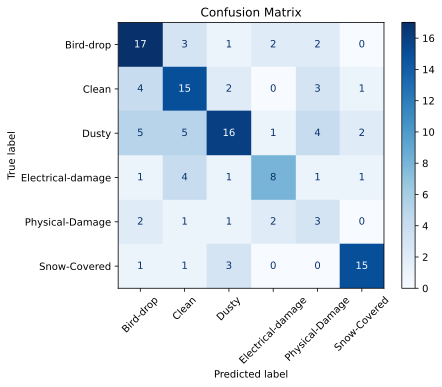

In [30]:
all_preds = []
all_labels = []
test_acc  = []

autoencoder.encoder.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        latent = autoencoder.encoder(images)
        outputs = classifier(latent)

        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        test_acc.append(100*torch.mean((preds == labels).float()).item())

print("Test Accuracy: ", f"{np.mean(test_acc):.2f}%")
cm = confusion_matrix(np.concatenate(all_labels), np.concatenate(all_preds))

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()